In [1]:

import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
%matplotlib inline
import sys

from scipy import stats
import numpy as np

In [2]:
# Global  parameters and Hyperparamaters

inpDir =os.path.abspath('C:\\lab9\\flowers') # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'flower_photos' # location of the images
modelDir = '../models' # location to save model files
valDir = 'valid_flowers' # location related to this dataset
altName = 'dropout_bn_no_bias_leaky_flowers' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE)


EPOCHS = 5   # number of cycles to run

ALPHA = 0.01

BATCH_SIZE = 16

TEST_SIZE = 0.2

IMG_HEIGHT = 156

IMG_WIDTH = 156

FLIP_MODE = "horizontal_and_vertical"

# for rotation transformation 
ROTATION_FACTOR = (-0.1, 0.1) 

FILL_MODE = 'nearest'

ES_PATIENCE = 20 # if performance does not improve stop

LR_PATIENCE = 10 # if performace is not improving reduce alpha

LR_FACTOR = 0.5 # rate of reduction of alpha



# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,6),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

# pick the input_shape 

input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    inpDir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    inpDir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 4317 files belonging to 5 classes.
Using 3454 files for training.
Found 4317 files belonging to 5 classes.
Using 863 files for validation.


In [3]:
class_names = train_ds.class_names
print('total ', len(class_names), class_names)

total  5 ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


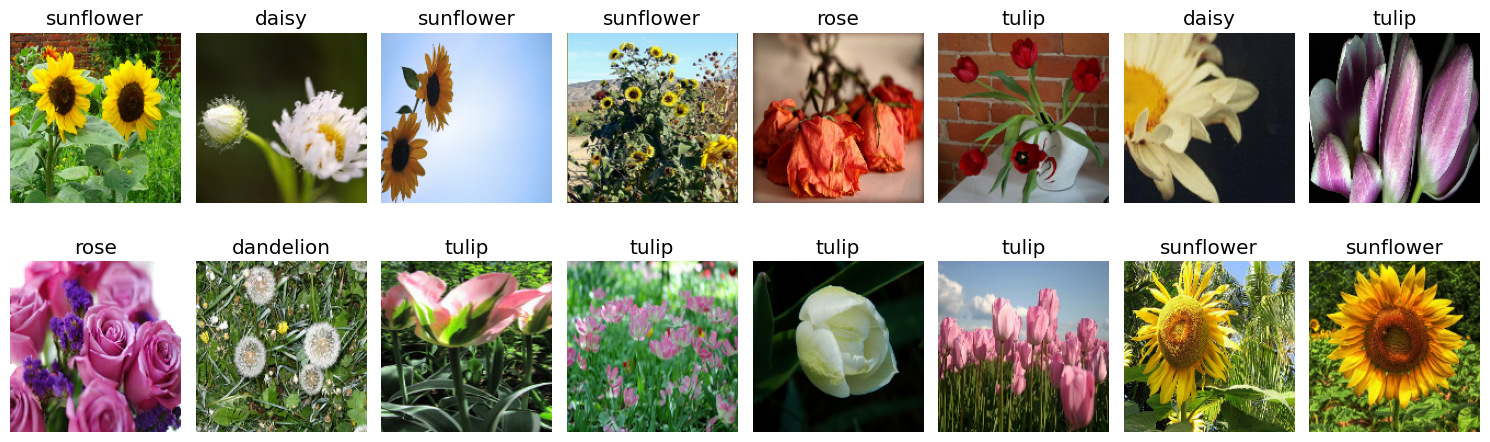

In [4]:
# set figure size
plt.figure(figsize=(15,5))

# take one batch of the dataset
for images, labels in train_ds.take(1):
    
    # iterate through the batch
    for i in range(BATCH_SIZE):
        
        # add a subplot
        plt.subplot(int(BATCH_SIZE/8), 8, i+1 )
        
        # switch off the grids
        plt.grid(False)
        
        # image_size may have converted these images to float
        plt.imshow(images[i].numpy().astype("uint8")) 
        
        # display class in the title
        plt.title(class_names[labels[i]])
        
        # no axis
        plt.axis("off")
        
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
# display all open images   

plt.show()


In [5]:
print(type(train_labels[0:16]))

NameError: name 'train_labels' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
print(images[1].numpy())
Xtrain, Xtest, ytrain, ytest = train_test_split(images[1].numpy(), train_labels[0:156],
                                                random_state=42)

In [6]:
# Function to plot number of classes in training and testing sets
def fn_plot_label(tr_ds, ts_ds):
    global train_labels,val_labels,x_values
    '''
        Args:
            tr_ds :  Training Dataset
            ts_ds : Testing dataset
        Returns : none
    '''

    # create figure
    plt.figure(figsize = (15,5))
    
    # create two subplots
    plt.subplot(1,2,1)

    # create array of training labels
    train_labels = tf.concat([y for x, y in tr_ds], axis = 0).numpy()
    x_values = tf.concat([x for x, y in tr_ds], axis=0).numpy()
    print(x_values.size)
    print(type(train_labels))
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(train_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center',color = 'DarkBlue', alpha = 0.7)
    
    # add title
    plt.title('Training Set')
    
    # add ticks on axis
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()


    #pick second image
    plt.subplot(1,2,2)

    # create array of testing labels 
    val_labels = tf.concat([y for x, y in ts_ds], axis = 0).numpy()
    
    # get unique labels and counts thereof
    unique, _, counts = tf.unique_with_counts(val_labels)
    
    # bar plot
    plt.bar(range(len(unique)), counts, align='center', color = 'Orange', alpha = 0.7)
    print(val_labels.size)
    # add title
    plt.title('Test Set')
    
    # add ticks
    plt.xticks(range(len(unique)), class_names)
    
    # grids make it look good
    plt.grid()
    
    # fit the subplot(s) in to the figure area
    plt.tight_layout()
    
    # display all open figures
    plt.show()


252169632
<class 'numpy.ndarray'>
863


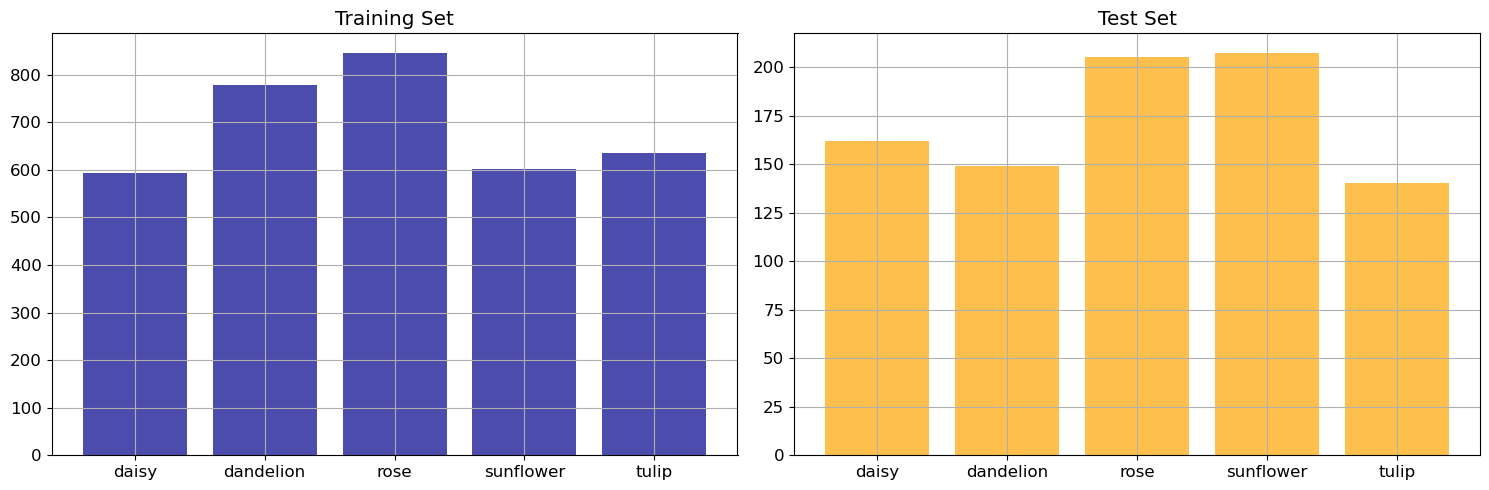

In [7]:
# how many examples in each of the class
fn_plot_label(train_ds, test_ds)


In [26]:
print(train_ds)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 156, 156, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


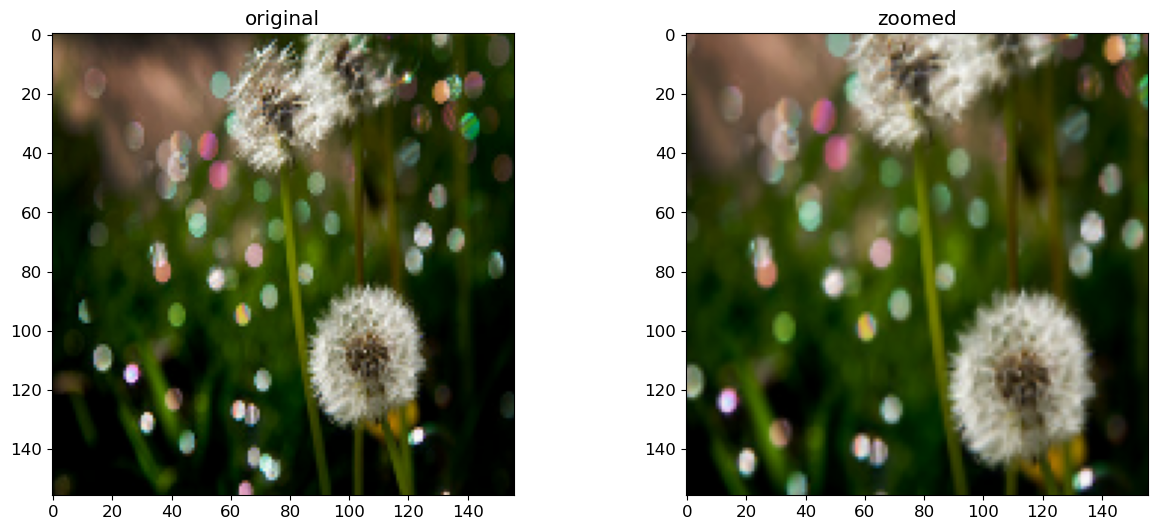

In [8]:
# Random Zoom

layer = tf.keras.layers.RandomZoom(height_factor=(-0.2,-0.2),width_factor=(-0.2,-0.2) )

plt.figure()

img_num = 6

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('zoomed')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))
 

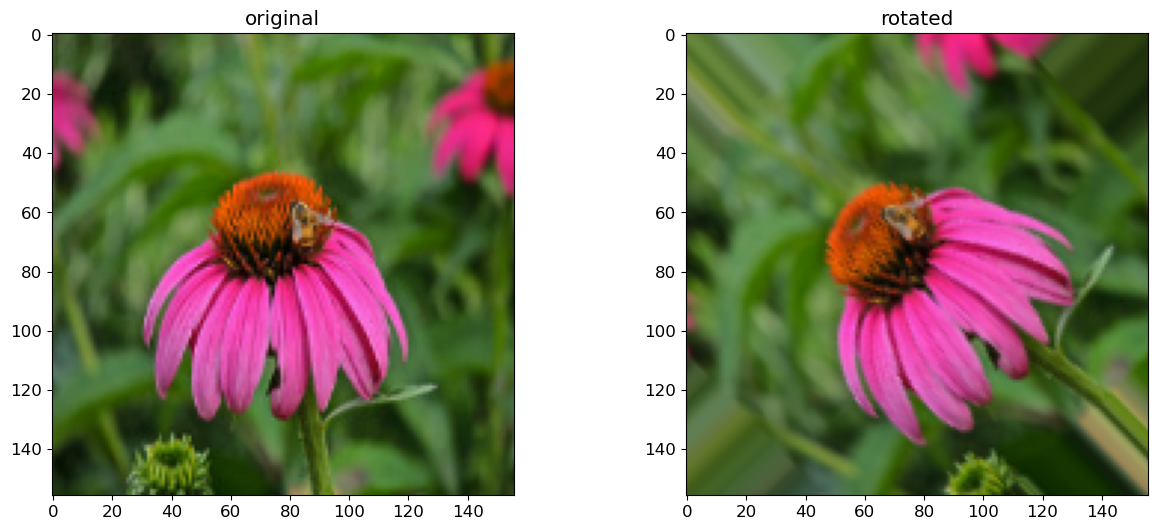

In [9]:
layer = tf.keras.layers.RandomRotation((-0.5, 0.5),
                                       fill_mode='nearest')

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('rotated')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

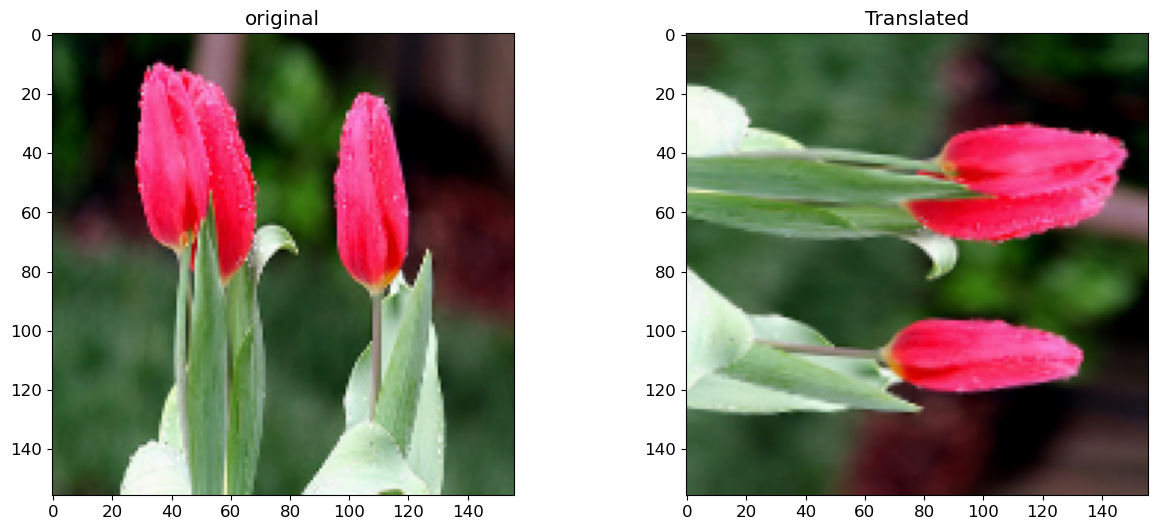

In [10]:
# Random Translation

tf.keras.layers.RandomTranslation(0.5,0.5,fill_mode='reflect',interpolation='bilinear')

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('Translated')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

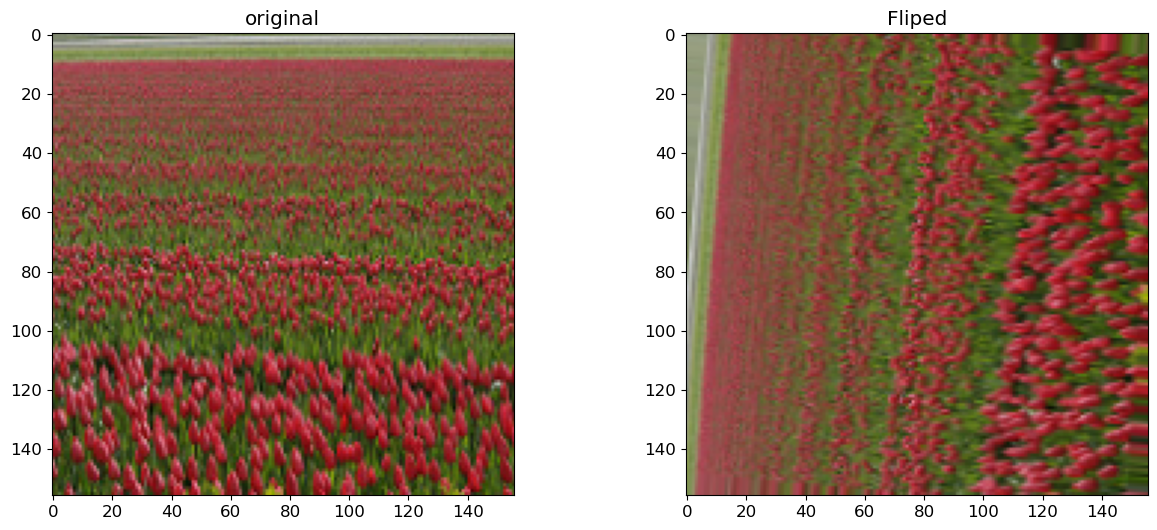

In [11]:
# Random Flip

tf.keras.layers.RandomFlip(mode="horizontal_and_vertical",seed=RANDOM_STATE)

plt.figure()

img_num = 3

for images, labels in train_ds.take(1):
    
    out_images = layer(images)
    
    plt.subplot(1,2,1)
    
    plt.title('original')
    
    plt.imshow(images[img_num].numpy().astype('uint8'))
    
    plt.subplot(1,2,2)
    
    plt.title('Fliped')
    
    plt.imshow(out_images[img_num].numpy().astype('uint8'))

In [12]:
import sklearn.tree as tree
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline # сборка конвейера обработки.

In [13]:
pca = PCA(n_components=156, whiten=True, random_state=42)
clf = tree.DecisionTreeClassifier (class_weight='balanced')


In [14]:

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('C:\\lab9/training/cp.ckpt', save_weights_only=True, verbose=1)


In [15]:
# определяем архитектуру модели
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(156, 156, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# определяем функцию потерь
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# определяем оптимизатор
optimizer = tf.keras.optimizers.Adam()

# создаем объект ModelCheckpoint
checkpoint_path = "C:\\lab9/training/cp.ckpt"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, save_weights_only=True, verbose=1)

# компилируем модель
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# обучаем модель
history = model.fit(train_ds, epochs=10, batch_size=32, callbacks=[checkpoint])


Epoch 1/10
216/216 [==============================] - ETA: 0s - loss: -2025954082816.0000 - accuracy: 0.2446
Epoch 1: saving model to C:\lab9/training\cp.ckpt
216/216 [==============================] - 68s 307ms/step - loss: -2025954082816.0000 - accuracy: 0.2446
Epoch 2/10
216/216 [==============================] - ETA: 0s - loss: -258798757347328.0000 - accuracy: 0.2446
Epoch 2: saving model to C:\lab9/training\cp.ckpt
216/216 [==============================] - 66s 306ms/step - loss: -258798757347328.0000 - accuracy: 0.2446
Epoch 3/10
216/216 [==============================] - ETA: 0s - loss: -3493842615533568.0000 - accuracy: 0.2446
Epoch 3: saving model to C:\lab9/training\cp.ckpt
216/216 [==============================] - 66s 306ms/step - loss: -3493842615533568.0000 - accuracy: 0.2446
Epoch 4/10
216/216 [==============================] - ETA: 0s - loss: -18880364848087040.0000 - accuracy: 0.2446
Epoch 4: saving model to C:\lab9/training\cp.ckpt
216/216 [==========================

In [17]:
for batch in train_ds:
    X.append(batch[0].numpy())
X = np.concatenate(X, axis=0)

NameError: name 'X' is not defined

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from skimage import io, color, feature
import numpy as np
import os

# Путь к папке с изображениями
path = 'C:\\lab9\\flowers'

# Список видов цветков для классификации
flower_types = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Создание пустых массивов для хранения признаков и меток классов
features = []
labels = []

# Извлечение признаков из каждого изображения
for flower_type in flower_types[:1]:
    folder_path = os.path.join(path, flower_type)
    print(folder_path)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = io.imread(image_path)
        # Извлечение гистограммы цветов
        hist1 = np.histogram(image[:,:,0], bins=8, range=(0, 255))[0]
        hist2 = np.histogram(image[:,:,1], bins=8, range=(0, 255))[0]
        hist3 = np.histogram(image[:,:,2], bins=8, range=(0, 255))[0]
        # Извлечение градиентов
        hog_features = feature.hog(color.rgb2gray(image), orientations=4, pixels_per_cell=(4, 4), cells_per_block=(2, 2))
        par=np.array([np.max(hog_features),np.min(hog_features),np.std(hog_features),np.mean(hog_features),np.median(hog_features)])
        # Объединение признаков в один массив
        all_features = np.concatenate((hist1,hist2,hist3,par ))
        # Добавление признаков и метки класса в массивы
        features.append(all_features)
        labels.append(flower_type)

# Преобразование массивов признаков и меток классов в numpy массивы
features = np.array(features)
labels = np.array(labels)

# Разделение данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Создание и обучение модели случайного леса
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Предсказание меток классов на тестовой выборке
y_pred = clf.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


C:\lab9\flowers\daisy


KeyboardInterrupt: 

In [18]:
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)


    ax = axes[0]

    hist_df.plot(y = [hist_df.columns[0],hist_df.columns[2]], ax = ax, colormap=CMAP)

    lossmin = hist_df[hist_df.columns[0]].min()

    testmin = hist_df[hist_df.columns[2]].min()

    txtstr = "Min {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[0],
                                                                          lossmin,
                                                                          testmin) 
    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

  
    ax.set_xlabel("Epochs")

    ax.set_ylabel(hist_df.columns[0].capitalize())

    ax.grid()

    ax = axes[1]

    hist_df.plot( y = [hist_df.columns[1], hist_df.columns[3]], ax = ax, colormap=CMAP)

    accmin = hist_df[hist_df.columns[1]].max()
    testmin = hist_df[hist_df.columns[3]].max()
    txtstr = "Max {}: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(hist_df.columns[1],
                                                                                accmin,
                                                                                testmin)
    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)


    ax.set_xlabel("Epochs")
    
    ax.set_ylabel(hist_df.columns[1].capitalize())
    
    ax.grid()

    plt.tight_layout()

    plt.show()

In [22]:
res_df1 =pd.DataFrame(history.history)
res_df1


loss  accuracy
0 -2.025954e+12  0.244644
1 -2.587988e+14  0.244644
2 -3.493843e+15  0.244644
3 -1.888036e+16  0.244644
4 -6.434175e+16  0.244644
5 -1.674989e+17  0.244644
6 -3.667264e+17  0.244644
7 -7.063623e+17  0.244644
8 -1.237204e+18  0.244644
9 -2.013269e+18  0.244644

In [33]:
print(all_features.shape)

print( hog_features.shape)


(35880,)
(41536,)


In [36]:
len(features)
hist.shape

(8,)

In [39]:
hist = np.histogram(image, bins=8, range=(0, 255))[0]

In [40]:
hist

array([19610, 31028, 34999, 21408, 10658,  4226,  3605,  4066],
      dtype=int64)

In [6]:
for flower_type in flower_types[:5]:
    folder_path = os.path.join(path, flower_type)
    print(folder_path)
    for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)
        image = io.imread(image_path)
        # Извлечение гистограммы цветов
        hist1 = np.histogram(image[:,:,0], bins=8, range=(0, 255))[0]
        hist2 = np.histogram(image[:,:,1], bins=8, range=(0, 255))[0]
        hist3 = np.histogram(image[:,:,2], bins=8, range=(0, 255))[0]
        # Извлечение градиентов
        hog_features = feature.hog(color.rgb2gray(image), orientations=4, pixels_per_cell=(4, 4), cells_per_block=(2, 2))
        par=np.array([np.max(hog_features),np.min(hog_features),np.std(hog_features),np.mean(hog_features),np.median(hog_features)])
        # Объединение признаков в один массив
        all_features = np.concatenate((hist1,hist2,hist3,par ))
        # Добавление признаков и метки класса в массивы
        features.append(all_features)
        labels.append(flower_type)
        print('.',end = ' ')


C:\lab9\flowers\daisy
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

In [7]:
# Преобразование массивов признаков и меток классов в numpy массивы
features = np.array(features)
labels = np.array(labels)

# Разделение данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Создание и обучение модели случайного леса
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Предсказание меток классов на тестовой выборке
y_pred = clf.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.6285414480587618


In [3]:
# Путь к папке с изображениями
path = 'C:\\lab9\\flowers'

# Список видов цветков для классификации
flower_types = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Создание пустых массивов для хранения признаков и меток классов
features = []
labels = []

In [9]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       daisy       0.72      0.81      0.76       267
   dandelion       0.54      0.65      0.59       191
        rose       0.58      0.37      0.45       150
   sunflower       0.74      0.67      0.71       150
       tulip       0.54      0.52      0.53       195

    accuracy                           0.63       953
   macro avg       0.62      0.61      0.61       953
weighted avg       0.63      0.63      0.62       953



In [12]:

from sklearn.neighbors import KNeighborsClassifier

In [16]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
# Предсказание меток классов на тестовой выборке
y_pred = knn.predict(X_test)

# Оценка точности модели
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4438614900314795


In [136]:
from sklearn.linear_model import  LogisticRegression
reg = LogisticRegression() # Создали объект линейная регрессия
reg.fit(X_train, y_train)# обучили
y_pred = reg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.4260230849947534


C:\program\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [106]:
set(y_train.tolist())
for flower_type in y_train.tolist():
        for a in flower_types:
            if flower_type == flower_types.index(a):
                flower_type+=flower_types.index(a)
            


In [124]:
b=[]
for flower_type in y_train.tolist():
        for a in flower_types:
            
            if flower_type == a:
                b.append(flower_types.index(a))
print(np.array(b)      )         

[2 2 0 ... 3 3 0]


In [71]:
a

(array([   8,   10,   25,   36,   42,   61,   62,   84,   93,   96,  103,
         110,  115,  119,  124,  166,  173,  175,  179,  189,  194,  197,
         202,  207,  208,  211,  245,  254,  256,  257,  268,  276,  286,
         303,  322,  323,  324,  332,  352,  371,  386,  387,  388,  395,
         396,  411,  412,  415,  426,  430,  434,  453,  460,  464,  467,
         479,  480,  485,  487,  491,  492,  495,  502,  505,  506,  511,
         516,  517,  518,  520,  523,  529,  532,  538,  539,  544,  550,
         552,  560,  562,  564,  576,  584,  585,  593,  605,  616,  619,
         644,  650,  658,  666,  670,  683,  685,  686,  712,  719,  721,
         723,  728,  751,  764,  770,  777,  779,  780,  786,  796,  818,
         823,  830,  840,  841,  843,  844,  846,  852,  856,  870,  880,
         882,  889,  892,  895,  901,  912,  924,  932,  940,  945,  949,
         956,  957,  961,  966,  973,  984,  999, 1001, 1007, 1010, 1013,
        1025, 1033, 1044, 1051, 1065, 